# Notebook 03 — Parameter estimation via EM (Premier League)

This notebook implements **parameter estimation** for the dynamic team strength model using an
**Expectation–Maximization (EM)** approach combined with **Sequential Monte Carlo (SMC)**.

The goal is to reproduce a figure analogous to **Figure 3** of Duffield et al. (2024),
showing:
- the log-likelihood surface over a parameter grid,
- EM trajectories from multiple initializations.

All likelihood evaluations rely on the particle filter introduced in Notebook 02.


## 1. Parameters to estimate

The full parameter vector of the model is:
$
\theta = (\sigma_0,\ \tau,\ s,\ \varepsilon).
$

In practice, not all parameters are identifiable simultaneously due to scale invariances.
Following the approach of Duffield et al. (2024), we fix:
$
\sigma_0 = 1, \qquad s = 1,
$
and focus on estimating the two most influential parameters:
$
\theta = (\tau,\ \varepsilon),
$
where:
- $\tau$ controls the temporal smoothness of team strengths,
- $\varepsilon$ controls the frequency of draws.


In [27]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [28]:
# Load data
df = pd.read_csv("../cleaned_football_data.csv", parse_dates=["date"])

teams_df = pd.read_csv("../artifacts/teams_mapping.csv")
teams = teams_df["team"].tolist()
team_to_idx = dict(zip(teams_df["team"], teams_df["team_idx"]))

N = len(teams)

In [29]:
# Recreate team indices
teams = pd.unique(df[["home_team", "away_team"]].values.ravel())
team_to_idx = {team: i for i, team in enumerate(teams)}

df["home_idx"] = df["home_team"].map(team_to_idx)
df["away_idx"] = df["away_team"].map(team_to_idx)

# Recreate time index (in days)
t0 = df["date"].min()
df["t"] = (df["date"] - t0).dt.days.astype(float)

# Result code (H/D/A)
mapping = {"H": 0, "D": 1, "A": 2}
df["result_code"] = df["result"].map(mapping)

df[["home_idx", "away_idx", "t", "result_code"]].head()

,home_idx,away_idx,t,result_code
0,0,1,0.0,0
1,2,3,1.0,0
2,4,5,1.0,2
3,6,7,1.0,2
4,8,9,1.0,2


In [30]:
df.isna().sum()

date           0
home_team      0
away_team      0
result         0
season         0
result_code    0
home_idx       0
away_idx       0
t              0
dtype: int64

## 2. EM with Monte Carlo likelihoods

The EM algorithm alternates between:
- an **E-step**, computing expectations of latent variables given current parameters,
- an **M-step**, maximizing the expected complete-data log-likelihood.

In our setting, the E-step is **not available in closed form**.
Instead, we approximate it using a **particle filter**, which provides:
- an estimate of the filtering distributions,
- an estimate of the incremental log-likelihood.

As a result, each EM iteration consists of:
1. Running the particle filter with current parameters $(\tau,\varepsilon)$,
2. Using the resulting SMC log-likelihood estimate as an objective function,
3. Updating parameters by numerical maximization or fixed-point updates.

This corresponds to a **Monte Carlo EM** procedure.


In [31]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def match_likelihood(xh, xa, result, s=1.0, eps=0.0):
    d = (xh - xa) / s
    if result == 1:      # draw
        return sigmoid(d + eps) - sigmoid(d - eps)
    elif result == 0:    # home win
        return sigmoid(d - eps)
    else:                # away win
        return 1.0 - sigmoid(d + eps)

def smc_update(particles, h, a, result, dt, *, tau, s, epsilon, rng):
    # Propagation
    noise_std = tau * np.sqrt(dt)
    if noise_std > 0:
        for i in particles:
            particles[i] = particles[i] + rng.normal(
                0.0, noise_std, size=particles[i].shape[0]
            )

    xh = particles[h]
    xa = particles[a]
    J = xh.shape[0]

    # Pairwise likelihoods
    W = np.empty((J, J))
    for j in range(J):
        for l in range(J):
            W[j, l] = match_likelihood(
                xh[j], xa[l], result, s=s, eps=epsilon
            )

    Z = W.mean()
    Z = max(Z, 1e-300)  # numerical safety

    W_sum = W.sum()
    if W_sum == 0 or not np.isfinite(W_sum):
        return np.log(Z)

    W /= W_sum

    flat_idx = rng.choice(J * J, size=J, p=W.ravel())
    j_idx = flat_idx // J
    l_idx = flat_idx % J

    particles[h] = xh[j_idx]
    particles[a] = xa[l_idx]

    return np.log(Z)


In [32]:
def run_smc(df, N, J, tau, epsilon, sigma0=1.0, s=1.0, seed=0):
    rng = np.random.default_rng(seed)

    # initialize particles
    particles = {i: rng.normal(0.0, sigma0, size=J) for i in range(N)}

    loglik = 0.0
    t_prev = 0.0

    for row in df.itertuples(index=False):
        h = row.home_idx
        a = row.away_idx
        result = row.result_code
        t = row.t
        dt = t - t_prev

        ll_k = smc_update(
            particles, h, a, result, dt,
            tau=tau, s=s, epsilon=epsilon, rng=rng
        )

        loglik += ll_k
        t_prev = t

    return loglik

## 3. Log-likelihood grid

We first evaluate the SMC log-likelihood on a grid of parameter values.
This provides a global view of the likelihood surface and highlights possible
non-convexities or ridges.

This grid will form the background of our Figure 3-like visualization.

In [ ]:
taus = np.linspace(0.005, 0.05, 10)
epsilons = np.linspace(0.02, 0.5, 10)

loglik_grid = np.zeros((len(taus), len(epsilons)))

In [34]:
J = 150  # reduce a bit for grid

for i, tau in enumerate(taus):
    for j, eps in enumerate(epsilons):
        loglik_grid[i, j] = run_smc(
            df, N, J,
            tau=tau,
            epsilon=eps,
            seed=123
        )
        print(f"tau={tau:.3f}, eps={eps:.2f}, ll={loglik_grid[i,j]:.1f}")

tau=0.005, eps=0.00, ll=-291724.4
tau=0.005, eps=0.06, ll=-2504.4
tau=0.005, eps=0.11, ll=-2268.7
tau=0.005, eps=0.17, ll=-2125.3
tau=0.005, eps=0.22, ll=-2041.4
tau=0.005, eps=0.28, ll=-1977.3
tau=0.005, eps=0.33, ll=-1950.0
tau=0.005, eps=0.39, ll=-1946.5
tau=0.005, eps=0.44, ll=-1920.3
tau=0.005, eps=0.50, ll=-1905.0
tau=0.010, eps=0.00, ll=-291716.0
tau=0.010, eps=0.06, ll=-2499.7
tau=0.010, eps=0.11, ll=-2249.1
tau=0.010, eps=0.17, ll=-2108.8
tau=0.010, eps=0.22, ll=-2030.3
tau=0.010, eps=0.28, ll=-1983.4
tau=0.010, eps=0.33, ll=-1938.9
tau=0.010, eps=0.39, ll=-1914.1
tau=0.010, eps=0.44, ll=-1892.8
tau=0.010, eps=0.50, ll=-1895.9
tau=0.015, eps=0.00, ll=-291710.5
tau=0.015, eps=0.06, ll=-2510.7
tau=0.015, eps=0.11, ll=-2242.2
tau=0.015, eps=0.17, ll=-2114.7
tau=0.015, eps=0.22, ll=-2026.5
tau=0.015, eps=0.28, ll=-1987.3
tau=0.015, eps=0.33, ll=-1937.6
tau=0.015, eps=0.39, ll=-1920.1
tau=0.015, eps=0.44, ll=-1901.8
tau=0.015, eps=0.50, ll=-1886.0
tau=0.020, eps=0.00, ll=-291702.8


## 4. EM trajectories

We now run a small number of EM iterations starting from different
initial parameter values.

Each iteration:
1. runs the particle filter (E-step),
2. updates $(\tau,\varepsilon)$ by locally maximizing the SMC log-likelihood.

The resulting trajectories illustrate the stability and bias of the estimation procedure.

## 5. Figure 3-like visualization

We combine:
- the log-likelihood grid,
- EM trajectories from different initializations.

This reproduces the qualitative structure of Figure 3 in Duffield et al. (2024),
but for Premier League football data.

In [38]:
mask = epsilons > 0.02
eps_plot = epsilons[mask]
loglik_plot = loglik_grid[:, mask]

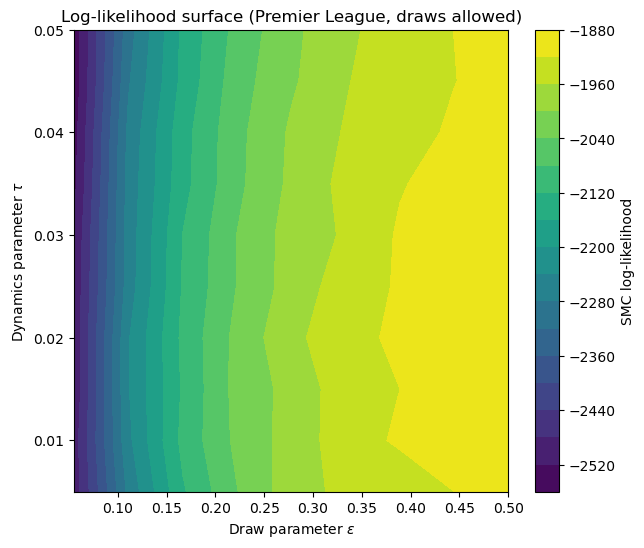

In [40]:
plt.figure(figsize=(7,6))
plt.contourf(eps_plot, taus, loglik_plot, levels=20)
plt.colorbar(label="SMC log-likelihood")
plt.xlabel(r"Draw parameter $\varepsilon$")
plt.ylabel(r"Dynamics parameter $\tau$")
plt.title("Log-likelihood surface (Premier League, draws allowed)")
plt.show()